In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import emcee
import os

import sys
sys.path.insert(0, '../')

Open the median-filtered K2 light curve, normalize

In [3]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 95)
k2_time_original, k2_flux_original = k2_time.copy(), k2_flux.copy()

Pull out just the chunk that has the repeated signal over two rotations:

In [4]:
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

<Container object of 3 artists>

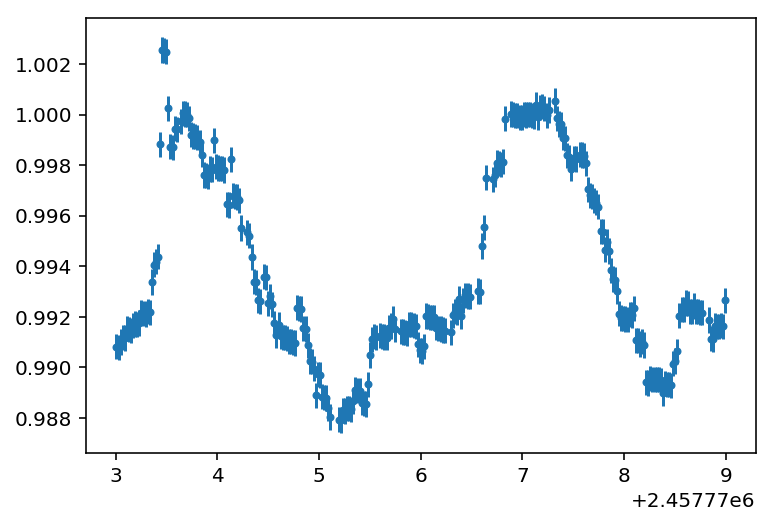

In [5]:
plt.errorbar(k2_time, k2_flux, k2_err, fmt='.')

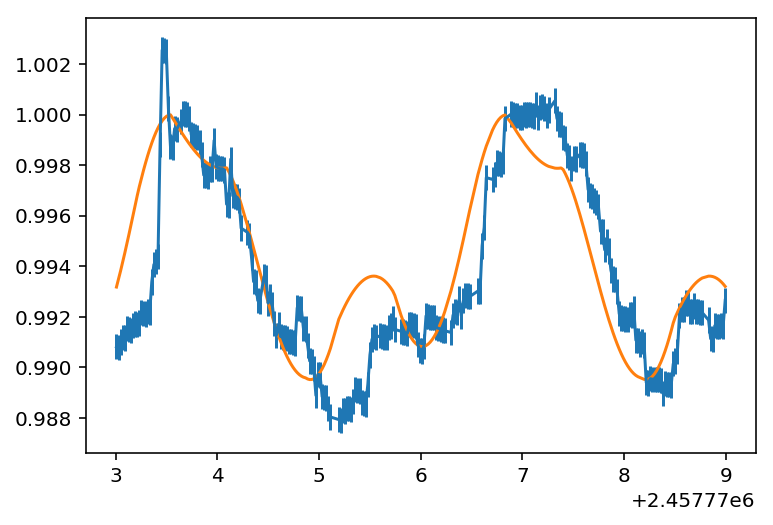

In [6]:
from libra import Spot, Star


spots = [Spot.from_latlon(0, 100, 0.18, contrast=0.7), 
         Spot.from_latlon(0, 220, 0.17, contrast=0.7), 
         Spot.from_latlon(0, 5, 0.1, contrast=0.7)]

star = Star(spots=spots, rotation_period=3.3*u.day)
model_flux =  star.flux(k2_time)
model_flux /= np.max(model_flux)

plt.errorbar(k2_time, k2_flux, k2_err)
plt.plot(k2_time, model_flux)

Use L-BFGS-B bounded minimizer to optimize for spot positions and radii for fixed contrasts. Compute reduced chi2 for each iteration.

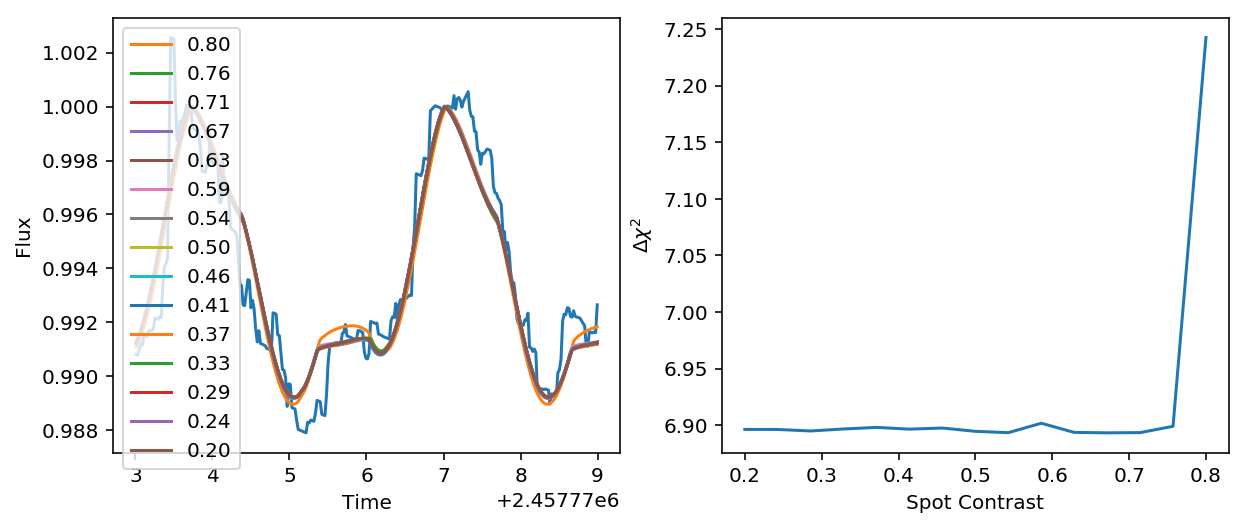

In [17]:
from astropy.utils.console import ProgressBar

def model(p, time, contrast):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2 = p
    
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=contrast)]

    star = Star(spots=spots, rotation_period=3.3*u.day)
    model_flux = star.flux(time)
    model_flux /= np.max(model_flux)

    return model_flux.value

def chi2(p, time, contrast):
    return np.sum((model(p, time, contrast) - k2_flux)**2 / (2 * k2_err)**2)

from scipy.optimize import fmin_l_bfgs_b, fmin_powell, fmin_slsqp, fmin_tnc

initp = np.array([0,   132,   0.2,
                  16,  238,   0.2,
                  -15,  60,   0.2])

bounds = [[-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1],
          [-89, 89], [0, 360], [0, 1]]

reduced_chi2 = []
contrasts = np.linspace(0.8, 0.2, 15)
results = []
dof = 9

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(k2_time, k2_flux)

with ProgressBar(len(contrasts), ipython_widget=True) as bar:
    median_radius = []

    for i, contrast in enumerate(contrasts):
        if i > 0:
            initp = results[-1] #+ 0.01 * np.random.randn()
        #result = fmin_l_bfgs_b(chi2, initp, args=(k2_time, contrast), approx_grad=True, bounds=bounds)[0]
        #result = fmin_slsqp(chi2, initp, args=(k2_time, contrast), bounds=bounds, iter=1000)
        result = fmin_tnc(chi2, initp, args=(k2_time, contrast), bounds=bounds, disp=True,
                  approx_grad=True)[0]
        red_chi2 = np.sum((model(result, k2_time, contrast) - k2_flux)**2 / k2_err**2) / (len(k2_time) - dof)
        reduced_chi2.append(red_chi2)
        results.append(result)
        median_radius.append(np.median(result[2::3]))
        bar.update()
        ax[0].plot(k2_time, model(result, k2_time, contrast), label="{0:.2f}".format(contrast))

    #ax[1].plot(contrasts, median_radius)

ax[0].legend()

ax[1].plot(contrasts, reduced_chi2)

ax[0].set(xlabel='Time', ylabel='Flux')

ax[1].set(xlabel='Spot Contrast', ylabel='$\Delta \chi^2$')

plt.show()